In [13]:
# cluster_reader.ipynb
# Authors: Stephan Meighen-Berger
# Loads and analyzes the results from dm_source_batch.py

In [25]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import UnivariateSpline
from scipy.optimize import root_scalar

In [15]:
# picture path
PICS = '../pics/'

In [16]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [64]:
# Plotting standards
std_size = 6.
fontsize = 20.
lw=1.
h_length=1.
mark_s = 10
export_dpi = 100
# params
mag_fit = 1.
colors = ['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000']
alphas = [0.2, 0.4, 0.6, 0.8, 1.]
# labels_mass = ['1\;TeV', '100\;TeV', '10\;PeV', '30\;TeV']
linest = ['-', '--', '-.', ':']

In [45]:
# Run parameters
ide_scan = [0, 10, 20, 30]
m_eborders = np.logspace(4., 8., 41)
m_ewidths = np.diff(m_eborders)
m_egrid = np.sqrt(m_eborders[1:]*m_eborders[:-1])
pop_list = range(2)[1:]
flux_scan = np.logspace(-24, -14, 51)

In [46]:
pop_store = []
for pop in pop_list:
    pop_store.append(pickle.load(open("..\\data\\cluster_sim\\cl_lim_res_pop_%d.p" %pop, "rb")))

In [47]:
len(pop_store[0][0])

51

In [55]:
# Fetching the flux values
plot_grid_y = []
for pop in range(len(pop_list)):
    tmp_plot_grid = []
    for ide in range(len(ide_scan)):
        spline = UnivariateSpline(flux_scan, pop_store[pop][ide], k=1, s=0)
        def root_flux(flux):
            return (spline(10**flux) - 0.9)
        sol = root_scalar(root_flux, bracket=[-26, -13], method='brentq')
        value = sol.root
        tmp_plot_grid.append(value)
    plot_grid_y.append(tmp_plot_grid)

In [51]:
plot_grid_y

[[-13.364377150465923, -17.22924653483378, -19.673341920198638, -21.8]]

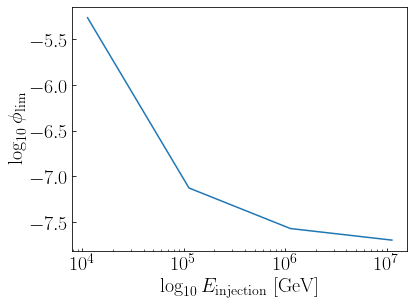

In [66]:
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# ---------------------------------------------
# Plotting
for pop in range(len(pop_list)):
    ax1.plot(m_egrid[ide_scan], np.array(plot_grid_y[pop]) +
                                np.log10(m_egrid[ide_scan]**2))
# ---------------------------------------------
# Axis options
ax1.set_xscale("log")
ax1.set_yscale("linear")
ax1.set_xlabel(r"$\log_{10} E_\mathrm{injection}\;[\mathrm{GeV}]$", fontsize=fontsize)
ax1.set_ylabel(r"$\log_{10}\phi_\mathrm{lim}$", fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ---------------------------------------------
# Legend
# plt.legend(fontsize=fontsize)
# h, l = ax1.get_legend_handles_labels()
# lgd1 = ax1.legend(h, l, loc=9, bbox_to_anchor=(0.5, +0.8),
#                     ncol=2, fontsize=fontsize, handlelength=h_length,
#                     fancybox=True, frameon=False)
# ax1.add_artist(lgd1)
# ---------------------------------------------
# Showing the image
plt.show()
# ---------------------------------------------
# Storing the image
figure.savefig(PICS + "source_limits_1PeV.png",
                bbox_inches='tight', dpi=export_dpi)